# Introduction to Julia for Data Science
## Classical predictive models (11:00-12:30)
Day 2 (Wednesday, Jan 18, 2023)


### Teaching objectives:
- Student will understand and know how to use in Julia Data Generating Process for Linear Regression Model
- Student will know how to estimate in Julia linear regression model using Ordinary Least Square
- Student will know the basic statistical properties of Ordinary Least Square and be able to demonstrate them in Monte Carlo simulations in Julia
- Student will be acquainted with omitted variable problem and its consequences. 

# Agenda (11:00 – 12:30)
1. Theoretical foundations of linear regression model (ca. 15 min):
    - a. Data Generating Process for Linear Regression Model,
    - b.	Ordinary Least Square estimator and its properties,
    - c.	Interpretation of coefficients and standard errors, p-values for statistical significance testing, as well as R-Squared,
    - d.	Consequence of omitted correlated variable problem. 
2. Practical verification of Ordinary Least Squares properties using simulations in Julia (ca. 75 min.):
    - a.	Synthetic data simulation according to linear regression (LR) Data Generating Process,
    - b.	Visualization of simulated data,
    - c.	Linear Regression estimation using Ordinary Least Squares (OLS),
    - d.	Interpretation linear regression results, i.e., estimated coefficients, standard error, p-values, R-squared,
    - e.	Demonstration of unbiasedness OLS property using Monte Carlo (MC) simulations,
    - f.	MC simulations of p-values assuming null hypothesis,
    - g.	Coefficient biasedness due to correlated omitted variable.

### Instructors:
- Bartosz Witkowski
- Mateusz Zawisza

## 2. Practical verification of Ordinary Least Squares properties using simulations in Julia (ca. 75 min.):
#### Loading installed packages


In [1]:
using Pkg
# add"DataFrames Plots GLM Markdown"  
# uncomment the above line when packages are not installed

In [2]:
using Random 
using DataFrames 
using Plots 
using Statistics 
using GLM # package for estimating Generalized Linear Models 
using Markdown


In [3]:
Random.seed!(1); # Setting a seed for random number generating to ensure a replicability

### a. Synthetic data simulation according to linear regression (LR) Data Generating Process,

#### Defining Data Generating Process (DGP)

A regional convenience store sells among others a bottled still water. Historically, the store set a price for this bottled water in relation to outside temperature, i.e. the higher temperarutre the higher price.
You'll be provided with a historical demand data composed of: temperature, rainfall, price and sales volume.
Our task for today is to find out the relationship between price and sales volume, so the store will be able to set the optimal price based on this relationship.

*dgp()* function simulates weekly store demand data for bottled still water and is composed of following variables / columns:
- temperature - average of temperature in Celcius degrees, an exogenous variable, non-depndent on remaining variables:

    $temperature_t = 10 + 5 \times \epsilon_t^{temperature}$
- rainfall - a weekly average of rainfall, correlated positively with temperature:

    $rainfall_t = max(0, temperature_t - 10 + 5 \times \epsilon_t^{rainfall}$)
- price - in Dollars for a large pack, driven positively by an average temperarture:

    $price_t = 14 + \frac{1}{10} \times temperature_t + \epsilon_t^{price}$
- demand - sales volume in unites, dependent negatively on  price and positivaly on temperature:

    $demand_t = \beta_0 + \beta_1\times price_t+\beta_2\times temperature_t+\epsilon_t^{demand}$.

Where:
- $\epsilon_t^{variable} \overset{\text{iid}}{\sim} \mathcal{N}(0, 1)$, $variable \in \{temperature, rainfall, price, demand\}$,
- $t\in\{1, ..., N\}$, $N$ - number of historical weeks.

In [4]:
function dgp(;
             N = 100, # number of observations
             β₀ = 30.0, # intercept / bias of linear regression, to be alligned with the rest of βs
             β₁ = -1.0, # 1st coefficient measuring the impact of price on demand / sales volume
             β₂ = 0.25)b # 2nd coefficient measuring the impact of temperature on demand / sales volume 
    temperature = 10 .+ 5 * randn(N) 
    rainfall = max.(0, temperature .- 10 + 5 * randn(N)) # rainfall depedends positively on temperature
    price = 14 .+ temperature / 10 + randn(N) / 2 # price depends positively on temperature
    demand = β₀ .+ β₁ * price + β₂ * temperature  + randn(N) 
    return DataFrame(; price, temperature, rainfall, demand)
end 
# footnote: an alternative function is make_regression() from MLJ pakcage

dgp (generic function with 1 method)

Generating a single dataset:

In [5]:
dataset = dgp()

LoadError: UndefVarError: b not defined

### b. Visualization of simulated data

Histogram of independent temperature variable:

In [8]:
histogram(dataset.temperature,
          xlab = "Temperature",
          bins = 15,
          legend = false)


LoadError: UndefVarError: dataset not defined

Scatterplot of temperature (x) impacting rainfall and price (y's):

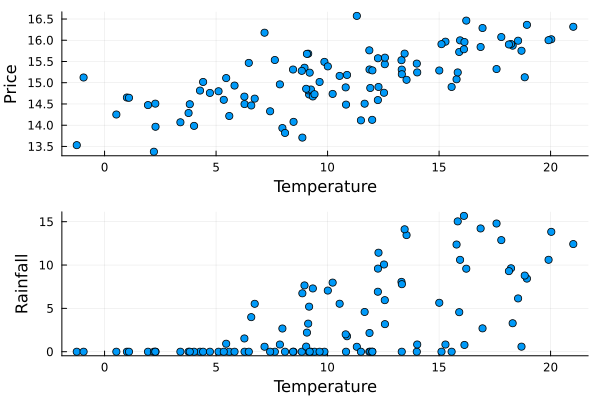

In [22]:
scatter(dataset.temperature,
        Matrix(dataset[!, [:price,:rainfall]]),
        layout = (2, 1),
        xlabel = "Temperature",
        ylabel = ["Price" "Rainfall"],
        legend = false)

Pearson correlations between temperature and [rainfall, price]:


In [23]:
cor(dataset.temperature,
    Matrix(dataset[!, [:price, :rainfall]]))

1×2 transpose(::Vector{Float64}) with eltype Float64:
 0.695653  0.628907

Scatterplot of demand vs temperature, rainfall and price:

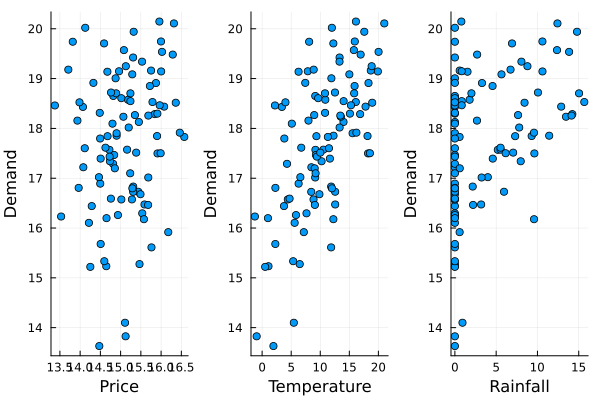

In [24]:
scatter(Matrix(dataset[!, 1:3]),
        dataset.demand,
        layout = (1, 3),
        ylabel = "Demand",
        xlabel = ["Price" "Temperature" "Rainfall"],
        legend = false)

Pearson correlations between demand and [temperature, rainfall, price]

In [25]:
cor(Matrix(dataset[!, 1:3]),
     dataset.demand)

3×1 Matrix{Float64}:
 0.15570112658874813
 0.6293024387533324
 0.4012572902307845

### c. Linear Regression estimation using Ordinary Least Squares (OLS)

#### Our own algebraic matrix implementation

Defining an estimating function:


In [27]:
least_squares(x, y) =  [ones(size(y)) x] \ y

least_squares (generic function with 1 method)

Using this function to estimate our linear regression:

In [28]:
βs = least_squares(Matrix(dataset[!, 1:3]), dataset.demand)


4-element Vector{Float64}:
 31.49419815110951
 -1.1000818704007713
  0.27202644889760075
 -0.004740913610126465

#### GLM package implementation

Defining model specification


In [29]:
specification = @formula(demand ~ price + temperature + rainfall)

FormulaTerm
Response:
  demand(unknown)
Predictors:
  price(unknown)
  temperature(unknown)
  rainfall(unknown)

Estimating a specified model on a given dataset:

In [31]:
fitted_OLS = lm(specification, dataset)


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

demand ~ 1 + price + temperature + rainfall

Coefficients:
────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error      t  Pr(>|t|)   Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)  31.4942       2.71373    11.61    <1e-19  26.1075     36.8809
price        -1.10008      0.191672   -5.74    <1e-06  -1.48055    -0.719615
temperature   0.272026     0.0298393   9.12    <1e-13   0.212796    0.331257
rainfall     -0.00474091   0.0258087  -0.18    0.8546  -0.0559709   0.046489
────────────────────────────────────────────────────────────────────────────

R² calculation:


In [32]:
R² = r2(fitted_OLS)


0.5503574784138726

### e. Demonstration of unbiasedness OLS property using Monte Carlo (MC) simulations


Initializing empty arrays to be populated by MC simulations' results 

In [33]:
estimation_columns =  ["β₀", "β₁", "β₂", "β₃", "β₃ p-value", "R²"]
estimation_results = DataFrame([column_name => Float64[] for column_name in estimation_columns])

Row,β₀,β₁,β₂,β₃,β₃ p-value,R²
,Float64,Float64,Float64,Float64,Float64,Float64


Setting up a number of Monte Carlo simulations:

In [34]:
N = 100_000

100000

Running Monte Carlo Simulations:


In [54]:
for i in 1:N
   dataset = dgp() # Data generation 
   fitted_OLS = lm(specification, dataset) # OLS fitting
   push!(estimation_results,
          [coef(fitted_OLS)[1:4] 
          DataFrame(coeftable(fitted_OLS))[4, 5]
          r2(fitted_OLS)]) 
end

In [25]:
estimation_results

Row,β₀,β₁,β₂,β₃,β₃ p-value,R²
,Float64,Float64,Float64,Float64,Float64,Float64
1,26.4799,-0.777719,0.264634,-0.029015,0.35864,0.490327
2,29.2691,-0.935733,0.229814,-0.00901395,0.7623,0.412625
3,28.471,-0.888485,0.231799,0.0193775,0.477494,0.507931
4,27.6403,-0.838216,0.23635,-0.0194676,0.550139,0.402918
5,29.6534,-0.969455,0.227045,0.00811323,0.813265,0.412873
6,26.8469,-0.804324,0.257414,0.025752,0.388028,0.510523
7,25.8997,-0.725225,0.227046,0.0162703,0.583994,0.469766
8,23.9971,-0.564423,0.185975,0.00303402,0.919,0.290454
9,29.3742,-0.97211,0.265699,-0.0314254,0.266315,0.5749


Sampling distribution of intercept OLS estimates

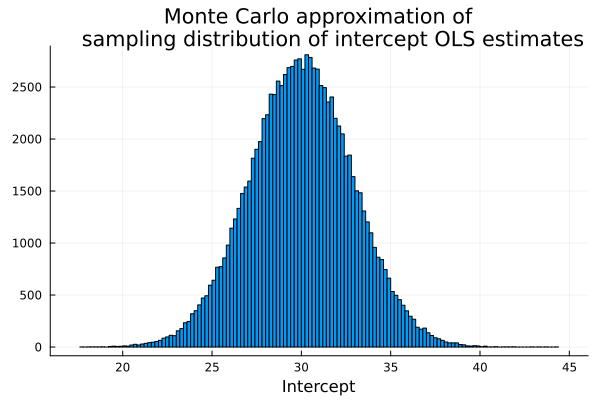

In [36]:
histogram(estimation_results.β₀,
    title = "Monte Carlo approximation of
    sampling distribution of intercept OLS estimates",
    xlabel = "Intercept",
    legend = false)

Key takeaways from sampling distribution of OLS intercept (β₀) estimates:

In [37]:
display(md"""
The intercept (β₀) estimated by Ordianary Least Squares (OLS) at the value of 
**$(round(DataFrame(coeftable(fitted_OLS))[1, 2], sigdigits = 3))**,
can be considered as a random variable derived from so called sampling distribution that 
we approximated (see histogram) through Monte Carlo simulations with:
1. a mean of **$(round(mean(estimation_results.β₀), sigdigits = 3))**
    equal to the true value of this parameter (unbiasedness property of an estimator),
2. a standard deviation (called standard error of this estimate) of **$(round(std(estimation_results.β₀), sigdigits = 3))** 
    being estimated by OLS to be 
    **$(round(DataFrame(coeftable(fitted_OLS))[1, 3],sigdigits = 3))**
    which is the minimal possible standard error (efficiency property of an estimator)
3. 95%-Confidence Interval of
    **$(string(round.(quantile(estimation_results.β₀, [0.025, 0.975]), sigdigits = 3)))**
    being estimated by OLS to be **$(string(round.(Vector(DataFrame(coeftable(fitted_OLS))[1, 6:7]), sigdigits = 3)))**.

Let us have a look at a last complete table:
<div>
$(PrettyTables.pretty_table(String, DataFrame(coeftable(fitted_OLS)),tf=PrettyTables.tf_html_dark))
</div>
""")


The intercept (β₀) estimated by Ordianary Least Squares (OLS) at the value of  **32.9**, can be considered as a random variable derived from so called sampling distribution that  we approximated (see histogram) through Monte Carlo simulations with:

1. a mean of **30.0**  equal to the true value of this parameter (unbiasedness property of an estimator),
2. a standard deviation (called standard error of this estimate) of **2.89**   being estimated by OLS to be   **2.85**  which is the minimal possible standard error (efficiency property of an estimator)
3. 95%-Confidence Interval of  **[24.3, 35.7]**  being estimated by OLS to be **[27.2, 38.5]**.

Let us have a look at a last complete table: <div> <table>
  <thead>
    <tr class = "header">
      <th style = "text-align: right;">Name</th>
      <th style = "text-align: right;">Coef.</th>
      <th style = "text-align: right;">Std. Error</th>
      <th style = "text-align: right;">t</th>
      <th style = "text-align: right;">Pr(&gt;|t|)</th>
      <th style = "text-align: right;">Lower 95%</th>
      <th style = "text-align: right;">Upper 95%</th>
    </tr>
    <tr class = "subheader headerLastRow">
      <th style = "text-align: right;">String</th>
      <th style = "text-align: right;">Float64</th>
      <th style = "text-align: right;">Float64</th>
      <th style = "text-align: right;">Float64</th>
      <th style = "text-align: right;">Float64</th>
      <th style = "text-align: right;">Float64</th>
      <th style = "text-align: right;">Float64</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style = "text-align: right;">(Intercept)</td>
      <td style = "text-align: right;">32.8766</td>
      <td style = "text-align: right;">2.8539</td>
      <td style = "text-align: right;">11.5199</td>
      <td style = "text-align: right;">8.47769e-20</td>
      <td style = "text-align: right;">27.2117</td>
      <td style = "text-align: right;">38.5416</td>
    </tr>
    <tr>
      <td style = "text-align: right;">price</td>
      <td style = "text-align: right;">-1.19326</td>
      <td style = "text-align: right;">0.202873</td>
      <td style = "text-align: right;">-5.8818</td>
      <td style = "text-align: right;">5.90243e-8</td>
      <td style = "text-align: right;">-1.59596</td>
      <td style = "text-align: right;">-0.790559</td>
    </tr>
    <tr>
      <td style = "text-align: right;">temperature</td>
      <td style = "text-align: right;">0.249277</td>
      <td style = "text-align: right;">0.029567</td>
      <td style = "text-align: right;">8.43092</td>
      <td style = "text-align: right;">3.4519e-13</td>
      <td style = "text-align: right;">0.190587</td>
      <td style = "text-align: right;">0.307967</td>
    </tr>
    <tr>
      <td style = "text-align: right;">rainfall</td>
      <td style = "text-align: right;">0.0240893</td>
      <td style = "text-align: right;">0.0261754</td>
      <td style = "text-align: right;">0.920303</td>
      <td style = "text-align: right;">0.359721</td>
      <td style = "text-align: right;">-0.0278684</td>
      <td style = "text-align: right;">0.0760469</td>
    </tr>
  </tbody>
</table>
 </div>


Sampling distribution of temperature, price and rainfall OLS estimates:

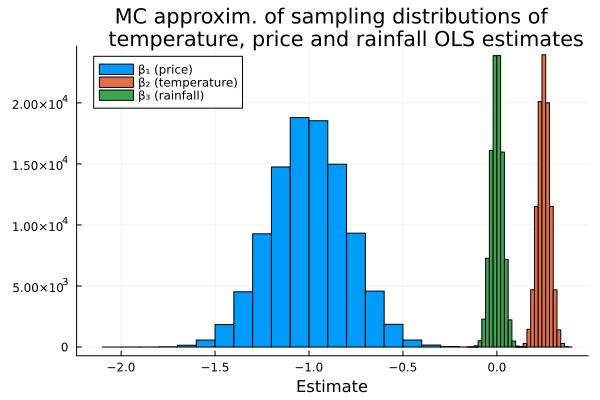

In [38]:
histogram(Matrix(estimation_results[!,2:4]),
    bins = 25, xlabel = "Estimate",
    labels = ["β₁ (price)" "β₂ (temperature)" "β₃ (rainfall)"],
    title = "MC approxim. of sampling distributions of
    temperature, price and rainfall OLS estimates")

Key takeaways from sampling distribution of OLS temperature estimates

In [39]:
display(md"""
The price impact coefficient (β₁) estimated by Ordianary Least Squares (OLS) at the value of ≈ **$(round(DataFrame(coeftable(fitted_OLS))[2, 2], sigdigits = 3))** can be considered as a random variable derived from so called sampling distribution that we approximated (see a blue histogram) through Monte Carlo simulations with:
1. a mean of ≈ **$(round(mean(estimation_results.β₁), sigdigits = 3))** equal to the true value of this parameter (unbiasedness property of an estimator),
2. a standard deviation (called standard error of this estimate) of ≈**$(round(std(estimation_results.β₁), sigdigits = 3))** being estimated by OLS to be **$(round(DataFrame(coeftable(fitted_OLS))[2, 3], sigdigits = 3))** - the minimal possible standard error (efficiency property of an estimator),
3.  95%-Confidence Interval of ≈ **$(round.(quantile(estimation_results.β₁, [0.025, 0.975]), sigdigits = 3))** being estimated by OLS to be **$(round.(Array(DataFrame(coeftable(fitted_OLS))[2, 6:7]), sigdigits = 3))**.
""")

The price impact coefficient (β₁) estimated by Ordianary Least Squares (OLS) at the value of ≈ **-1.19** can be considered as a random variable derived from so called sampling distribution that we approximated (see a blue histogram) through Monte Carlo simulations with:

1. a mean of ≈ **-0.999** equal to the true value of this parameter (unbiasedness property of an estimator),
2. a standard deviation (called standard error of this estimate) of ≈**0.206** being estimated by OLS to be **0.203** - the minimal possible standard error (efficiency property of an estimator),
3. 95%-Confidence Interval of ≈ **-1.4-0.594** being estimated by OLS to be **-1.6-0.791**.


Key takeaways from sampling distribution of price OLS estimates

In [40]:
println("The temperature impact coefficient (β₂) estimated by Ordianary Least Squares (OLS) at the value of ≈",
    round(DataFrame(coeftable(fitted_OLS))[3, 2],
        sigdigits = 3),
    " can be considered as a random variable derived from so called sampling distribution that we approximated (see an orange histogram) through Monte Carlo simulations with:\n",
    "(1) a mean of ≈",
    round(mean(estimation_results.β₂), sigdigits = 3),
    " equal to the true value of this parameter (unbiasedness property of an estimator),\n",
    "(2) a standard deviation (called standard error of this estimate) of ≈",
    round(std(estimation_results.β₂), sigdigits = 3),
    " being estimated by OLS to be ",
    round(DataFrame(coeftable(fitted_OLS))[3, 3],
        sigdigits = 3),
    " - the minimal possible standard error (efficiency property of an estimator),\n",
    "(3) 95%-Confidence Interval of ≈",
    round.(quantile(estimation_results.β₂, [0.025, 0.975]),
        sigdigits = 3),
    " being estimated by OLS to be ",
    round.(Array(DataFrame(coeftable(fitted_OLS))[3, 6:7]),
        sigdigits = 3),
    ".")

The temperature impact coefficient (β₂) estimated by Ordianary Least Squares (OLS) at the value of ≈0.249 can be considered as a random variable derived from so called sampling distribution that we approximated (see an orange histogram) through Monte Carlo simulations with:
(1) a mean of ≈0.25 equal to the true value of this parameter (unbiasedness property of an estimator),
(2) a standard deviation (called standard error of this estimate) of ≈0.033 being estimated by OLS to be 0.0296 - the minimal possible standard error (efficiency property of an estimator),
(3) 95%-Confidence Interval of ≈[0.185, 0.315] being estimated by OLS to be [0.191, 0.308].


Key takeaways from sampling distribution of rainfall OLS estimates:

In [41]:
println("The rainfall impact coefficient (β₃) estimated by Ordianary Least Squares (OLS) at the value of ≈",
    round(DataFrame(coeftable(fitted_OLS))[4, 2],
        sigdigits = 3),
    " can be considered as a random variable derived from so called sampling distribution that we approximated (see a green histogram) through Monte Carlo simulations with:\n",
    "(1) a mean of ≈",
    round(mean(estimation_results.β₃), sigdigits = 3),
    " equal to the true value of this parameter (unbiasedness property of an estimator),\n",
    "(2) a standard deviation (called standard error of this estimate) of ≈",
    round(std(estimation_results.β₃), sigdigits = 3),
    " being estimated by OLS to be ",
    round(DataFrame(coeftable(fitted_OLS))[4, 3],
        sigdigits = 3),
    " - the minimal possible standard error (efficiency property of an estimator),\n",
    "(3) 95%-Confidence Interval of ≈",
    round.(quantile(estimation_results.β₃, [0.025, 0.975]),
        sigdigits = 3),
    " being estimated by OLS to be ",
    round.(Array(DataFrame(coeftable(fitted_OLS))[4, 6:7]),
        sigdigits = 3),
    ".")

The rainfall impact coefficient (β₃) estimated by Ordianary Least Squares (OLS) at the value of ≈0.0241 can be considered as a random variable derived from so called sampling distribution that we approximated (see a green histogram) through Monte Carlo simulations with:
(1) a mean of ≈-0.000161 equal to the true value of this parameter (unbiasedness property of an estimator),
(2) a standard deviation (called standard error of this estimate) of ≈0.0315 being estimated by OLS to be 0.0262 - the minimal possible standard error (efficiency property of an estimator),
(3) 95%-Confidence Interval of ≈[-0.0623, 0.0616] being estimated by OLS to be [-0.0279, 0.076].


Sampling distribution of rainfall significance test p-values:

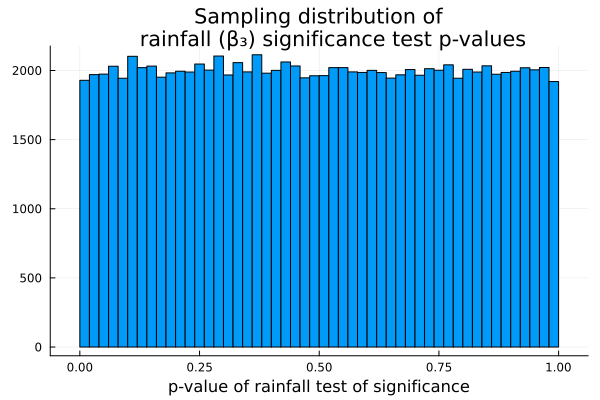

In [42]:
histogram(estimation_results."β₃ p-value",
    xlabel = "p-value of rainfall test of significance",
    title = "Sampling distribution of
    rainfall (β₃) significance test p-values",
    legend = false)


Key takeaways from Sampling distribution of rainfall significance test p-values:

In [43]:
print("Given the null hypothesis of no impact of rainfall being true, the sampling distribution of p-values will be uniform on [0, 1] - see a histogram above.")
println("As a result, using the significance level of α = 5% will result in rejecting the true null hypothesis (so called type I error or false positive) of no rainflall impact on demand as often as ",
    round(mean(estimation_results."β₃ p-value" .< 0.05), sigdigits = 3) * 100,
    "% of times (being equal to α = 5%)."
)

Given the null hypothesis of no impact of rainfall being true, the sampling distribution of p-values will be uniform on [0, 1] - see a histogram above.As a result, using the significance level of α = 5% will result in rejecting the true null hypothesis (so called type I error or false positive) of no rainflall impact on demand as often as 4.9% of times (being equal to α = 5%).


Key takeaways:
- It's unavoidable to make a type I error (false positive), so be aware of it, whenever you claim the impact of X, e.g. rainfall,  on Y, e.g. demand,
- You're controlling the probability of type I error (false positive) by setting up the significance level, e.g. α ∈ [1%, 5%, 10%],,
- However, there's no free lunch, but a trade-off, since the lower the probability of false positive, e.g. α ∈ [1%, 5%, 10%], the higher the probability of so called type II error (false negative), which is failing to reject a false null hypothesis. This type of error is higher the smaller data is, so you might want to choose higher α e.g. 5%, 10% for smaller data and smaller  α e.g. 1% or 5% for bigger data.

Key takeaways from Sampling distribution of R²

In [44]:
println("The coefficient of determination (R²) estimated by Ordianary Least Squares (OLS) at the value of ≈",
    round(r2(fitted_OLS), sigdigits = 3),
    " can be considered as a random variable derived from so called sampling distribution that we approximated through Monte Carlo simulations with:\n",
    "(1) a mean of ≈",
    round(mean(estimation_results.R²), sigdigits = 3),
    "\n(2) a standard deviation (called standard error of this estimate) of ≈",
    round(std(estimation_results.R²), sigdigits = 3),
    "\n(3) 95%-Confidence Interval of ≈",
    round.(quantile(estimation_results.R², [0.025, 0.975]),
        sigdigits = 3),
    ".")

The coefficient of determination (R²) estimated by Ordianary Least Squares (OLS) at the value of ≈0.543 can be considered as a random variable derived from so called sampling distribution that we approximated through Monte Carlo simulations with:
(1) a mean of ≈0.46
(2) a standard deviation (called standard error of this estimate) of ≈0.0731
(3) 95%-Confidence Interval of ≈[0.312, 0.597].


### g. Coefficient biasedness due to correlated omitted variable


Defining a simple but wrong specification omitting both temperature and rainfall:


In [45]:
wrong_specification = @formula(demand ~ price)

FormulaTerm
Response:
  demand(unknown)
Predictors:
  price(unknown)

Estimating a wrongly specified model:

In [46]:
wrong_spec_model = lm(wrong_specification, dataset)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

demand ~ 1 + price

Coefficients:
────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error     t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  11.8783      2.78568   4.26    <1e-04  6.35022    17.4064
price         0.377289    0.184462  2.05    0.0435  0.0112301   0.743347
────────────────────────────────────────────────────────────────────────

Initializing an empty array to be popoulated by price coefficients:

In [47]:
biased_estimate_names =  ["β₁", "β₁ p-value"]
biased_estimates = DataFrame([column_name => Float64[] for column_name in biased_estimate_names])

Row,β₁,β₁ p-value
,Float64,Float64


Running Monte Carlo Simulations:

In [48]:
for i in 1:N
  dataset = dgp() # data generation
  wrong_spec_model = lm(wrong_specification, dataset) # wrong model fitting
  push!(biased_estimates,[coef(wrong_spec_model)[2] DataFrame(coeftable(wrong_spec_model))[2, 5]])
end

Sampling distribution of price coefficient in a wrongly specified model:

In [49]:
biased_estimates
    

Row,β₁,β₁ p-value
,Float64,Float64
1,0.209704,0.246201
2,0.194946,0.279086
3,0.300883,0.067031
4,0.354802,0.0741783
5,0.0245609,0.895874
6,0.265175,0.0771419
7,0.193633,0.275109
8,0.148443,0.465578
9,0.215608,0.2628


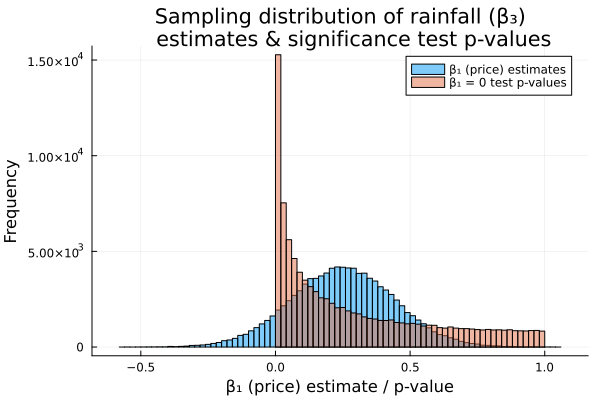

In [50]:
histogram(Matrix(biased_estimates),
    fillalpha=0.5,
    xlabel = "β₁ (price) estimate / p-value",
    ylabel = "Frequency",
    title = "Sampling distribution of rainfall (β₃)
    estimates & significance test p-values",
    labels = ["β₁ (price) estimates" "β₁ = 0 test p-values"])

Calculating a bias being a difference between the expected value of an estimate and a true value:

In [51]:
bias =  mean(biased_estimates.β₁) - (-1)

1.2494670231448823

Main takeaways from omitted variable problem:


In [1]:
println("OLS estimate of price coefficient is biased, i.e. systematically being wrong with an expected value of ≈",
    round(mean(biased_estimates.β₁), sigdigits = 3),
    ".\nGiven a true price coefficient value of -1, the total bias is equal to (",
    round(mean(biased_estimates.β₁), sigdigits = 3),
    " - (-1)) = ", round(bias, sigdigits = 3))
println("This bias is due to the omitted variable, i.e. temperature impacting both price and demand, e.g. ommiting a rainfall doesn't result in a bias even though it is correlated with price but not impacting a demand.")
println("Since the temprerature is impacting both demand and price, when ommited its postive impact on demand is overtaken by the price, which results in a biased price impact estimation.") 


LoadError: UndefVarError: biased_estimates not defined

*Preparation of this workshop has been supported by the Polish National Agency for Academic Exchange under the Strategic Partnerships programme, grant number BPI/PST/2021/1/00069/U/00001.*

![SGH & NAWA](logo.png)